# Analysing the 1D shock tube test

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u

import richio
richio.plots.use_nice_style()

In [2]:
import warnings

def _get_at_x(snap,
           quantity, 
           x, 
           xeps=0.05,
           qeps=1e-2):
    """
    Get quantity at x=indices, with coordinate error within xeps and quantity
    error within qeps.
    """
    try:
        indices = np.abs(snap.x - x * snap.x.units) <= xeps * snap.x.units
    except:
        indices = np.abs(snap.x - x) <= xeps * snap.x.units
    qxs = quantity[indices]

    qerr = (np.max(qxs) - np.min(qxs)) / np.min(qxs)
    if qerr > qeps: # percentage error
        warnings.warn(f"Error is {qerr}.")
    
    return np.mean(qxs)

In [3]:
!ls /home/hey4/rich_tde/data/raw/

ApptainerTDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
N1e6TDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
NewbuildTDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
SedovDissipation
ShockTubeN1e3IdealGas
ShockTubeN1e3OndrejEOS
ShockTubeN1e4IdealGas
ShockTubePL100PR1e-3N1e3
ShockTubePL10PR1e-2N1e3
ShockTubePL1e3PR1e-4N1e3
ShockTubePR1e-2N1e3IdealGas
ShockTubeSodN1e3Lbox2
etc
sedov2d
sedov2dMPI
sedov3d
sedov3dMPI


In [4]:
# snap_dir = '/home/hey4/rich_tde/data/raw/ShockTubePL100PR1e-3N1e3'
snap_dir = '/home/hey4/RICH-fwrk/build/'
!ls $snap_dir

CMakeCache.txt	     snap_1300	     snap_1900.pvtu  snap_400.h5
CMakeFiles	     snap_1300.h5    snap_200	     snap_400.pvtu
Makefile	     snap_1300.pvtu  snap_200.h5     snap_500
cmake_install.cmake  snap_1400	     snap_200.pvtu   snap_500.h5
rich		     snap_1400.h5    snap_2000	     snap_500.pvtu
snap_0		     snap_1400.pvtu  snap_2000.h5    snap_600
snap_0.h5	     snap_1500	     snap_2000.pvtu  snap_600.h5
snap_0.pvtu	     snap_1500.h5    snap_2100	     snap_600.pvtu
snap_100	     snap_1500.pvtu  snap_2100.h5    snap_700
snap_100.h5	     snap_1600	     snap_2100.pvtu  snap_700.h5
snap_100.pvtu	     snap_1600.h5    snap_2200	     snap_700.pvtu
snap_1000	     snap_1600.pvtu  snap_2200.h5    snap_800
snap_1000.h5	     snap_1700	     snap_2200.pvtu  snap_800.h5
snap_1000.pvtu	     snap_1700.h5    snap_2300	     snap_800.pvtu
snap_1100	     snap_1700.pvtu  snap_2300.h5    snap_900
snap_1100.h5	     snap_1800	     snap_2300.pvtu  snap_900.h5
snap_1100.pvtu	     snap_1800.h5    snap_300	     

In [ ]:
# for snapnum in range(3000, 100000, 100):
#     file1 = snap_dir + f'snap_{snapnum}.pvtu'
#     file2 = snap_dir + f'snap_{snapnum}.h5'
#     dir = snap_dir + f'snap_{snapnum}'
#     !rm $file1
#     !rm $file2
#     !rm -r $dir

In [11]:
snap = richio.load(os.path.join(snap_dir, 'snap_2300.h5')) # 900

In [12]:
snap.info()

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /home/hey4/RICH-fwrk/build/snap_2300.h5
  Snapshot Number           : 2300
  Time                      : [4.71453249] code_time
  Box size                  : [-10.    -0.01  -0.01  10.     0.01   0.01] code_length
  Cycle                     : [2300.] dimensionless
  Number of Cells           : 1,000
  Number of Ranks           : 24

Available Fields                         [Unit System: RICH]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
Box             code_length                              box_s

In [13]:
snap.time

unyt_array([4.71453249], 'code_time')

## The rho v P profiles

In [14]:
from rs import RiemannSolver
# Left State
rho_L = 1.0
vx_L = 0.0
P_L = 1

# Right State
rho_R = 0.125
vx_R = 0.0
P_R = 0.1

# ideal gas gamma
gamma = 5/3

# time
t = snap.time.value

# Riemann Solver
rs = RiemannSolver(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
x, rho, vx, P = rs.solve()

x *= richio.units.system["length"]
rho *= richio.units.system["density"]
vx *= richio.units.system["velocity"]
P *= richio.units.system["pressure"]

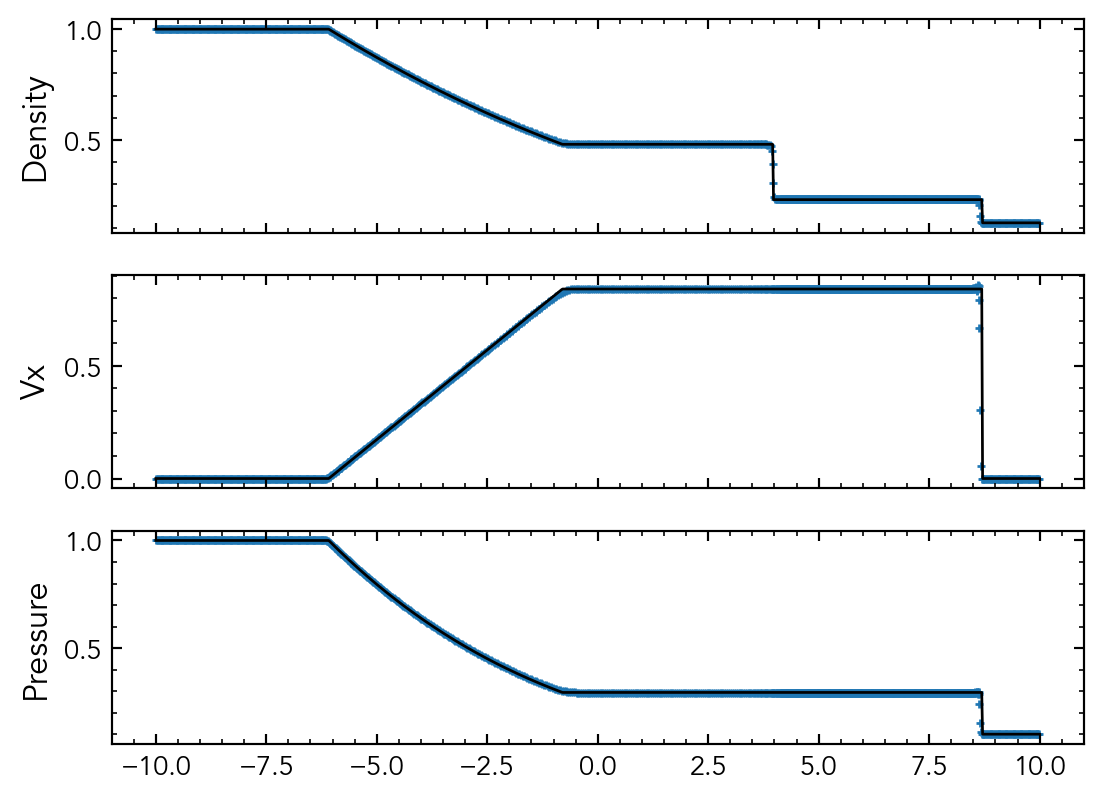

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(x, rho, color='k')
ax[0].scatter(snap.x, snap.density, marker='+',  s=10)
ax[0].set_ylabel('Density')

ax[1].plot(x, vx, color='k')
ax[1].scatter(snap.x, snap.velocity_x, marker='+',  s=10)
ax[1].set_ylabel('Vx')

ax[2].plot(x, P, color='k')
ax[2].scatter(snap.x, snap.P, marker='+',  s=10)
ax[2].set_ylabel('Pressure')

plt.show()

## Dissipation
Sackur–Tetrode equation: entropy of an monatomic ideal gas ($\gamma = 5/3$)
$$
\frac{S}{k_{\rm B} N} = \ln
\left[ \frac{V}{N} \left(\frac{4\pi m}{3h^2}\frac{U}{N}\right)^{3/2}\right]+
{\frac{5}{2}}
$$
Specific entropy expressed in terms of pressure and density
$$
s = \frac{k_B}{m_H} \left\{ \ln\left[m_H^4 \left(\frac{2\pi}{h^2}\right)^{3/2}\frac{P}{\rho^{\gamma}}\right] + \frac{5}{2} \right\}
$$

In [16]:
def dp2s(rho, p):
    """
    Using the Sackur-Tetrode equation to calculate specific entropy of a
    gamma=5/3 ideal gas, given pressure and density.
    """
    gamma = 5/3
    sie = p / (rho * (gamma - 1)) # specific internal energy
    s = 1 / u.mh * u.kb * (np.log(u.mh / rho * ((4*np.pi*u.mh**2*sie)/(3*u.h**2))**(3/2)) + 5/2) 
    return s

In [17]:
# Specific entropy of the cells
s = dp2s(snap.rho, snap.P)
s = (s * snap.density / snap.density).in_base('rich') # unit hack

# Specific entropy of the analytical solution
s_exact = dp2s(rho, P)
# Create new quantity with rich registry
s_exact = u.unyt_array(
    s_exact.value,  # or s_exact.value
    s_exact.units,
    registry=richio.units.registry
)
s_exact = s_exact.in_base('rich')

### Measure sh speed

In [18]:
_xs = []
_ts = []
for file in os.listdir(snap_dir):
    if file.endswith('h5'):
        _snap = richio.load(os.path.join(snap_dir, file))
        i_shfront = np.argmax(_snap.dissipation) # sh front as the maximum of dissipation, good enough for sod sh; be careful in other setups
        _x = _snap.x[i_shfront]
        _t = _snap.time[0]

        _xs.append(_x)
        _ts.append(_t)

_xs = u.unyt_array(_xs)
_ts = u.unyt_array(_ts)

1.834879628014227 code_length/code_time 0.005446696882925227 code_length


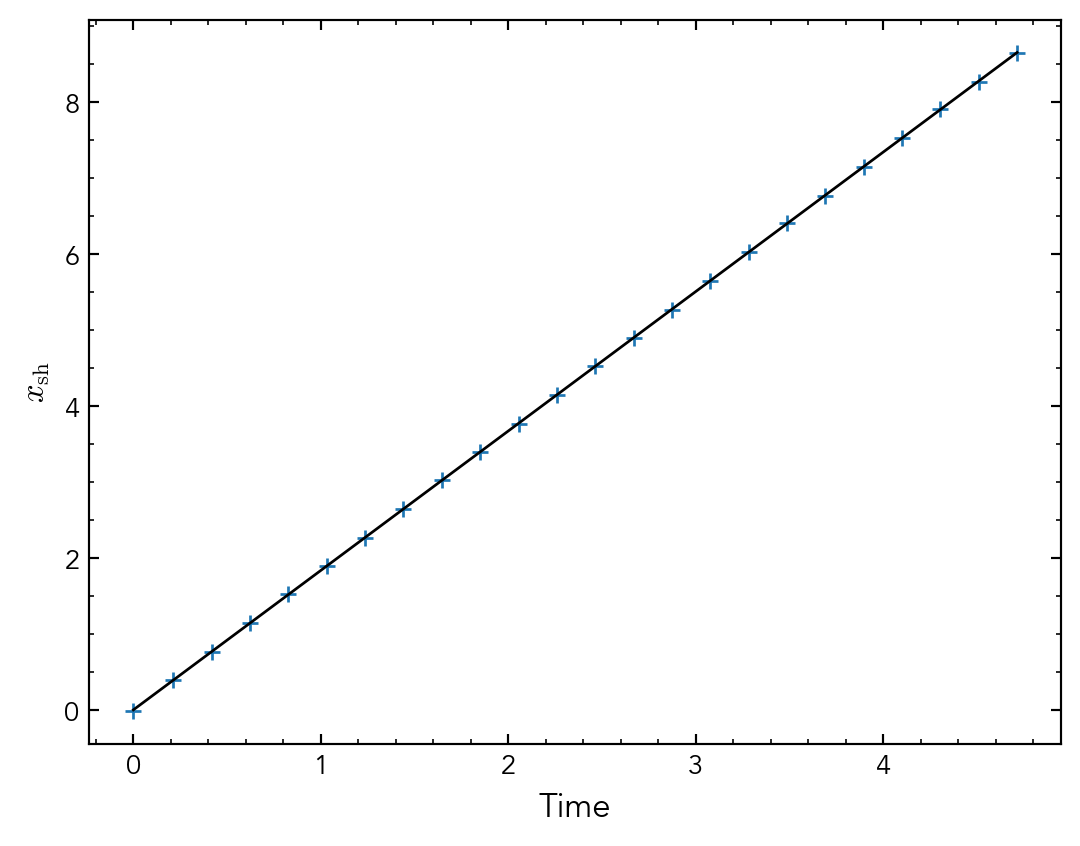

In [19]:
v_sh, b = np.polyfit(_ts.value, _xs.value, 1)
v_sh *= richio.units.lscale / richio.units.tscale
b *= richio.units.lscale
print(v_sh, b)

plt.scatter(_ts, _xs, marker='+')
_t = np.linspace(np.min(_ts), np.max(_ts), 100, True)
plt.plot(_t, _t*v_sh + b, color='k')
plt.xlabel('Time')
plt.ylabel(r'$x_\mathrm{sh}$')
plt.show()

In [20]:
np.sum(_ts < _ts[np.argmax(_xs)])

np.int64(23)

### Verify jump conditions
$$
\frac{\rho_1}{\rho_2} = \frac{\gamma - 1}{\gamma + 1} + \frac{2}{(\gamma + 1) M^2}
$$
$$
\frac{P_2}{P_1} = \frac{2\gamma M^2}{\gamma + 1} - \frac{\gamma - 1}{\gamma + 1}
$$
$$
\frac{u_2}{u_1} = \frac{P_2}{P_1}\frac{\rho_1}{\rho_2}
$$

In [21]:
# Get sh front position
i_sh = np.argmax(snap.dissipation)
x_sh = snap.x[i_sh]

# Near the neighbor of the sh front
x1 = x_sh * 1.1  # upstream
x2 = x_sh * 0.9  # downstream

In [22]:
# Temperature
T = snap.P / snap.density * u.mh / u.kb

# Analytical solution of temperature
T_exact = P / rho * u.mh / u.kb

In [23]:
T1 = _get_at_x(snap, T, x=x1)
T2 = _get_at_x(snap, T, x=x2)
s1 = _get_at_x(snap, s, x=x1)
s2 = _get_at_x(snap, s, x=x2)
u1 = _get_at_x(snap, snap.sie, x=x1)
u2 = _get_at_x(snap, snap.sie, x=x2)
rho1 = _get_at_x(snap, snap.rho, x=x1)
rho2 = _get_at_x(snap, snap.rho, x=x2)
P1 = _get_at_x(snap, snap.P, x=x1)
P2 = _get_at_x(snap, snap.P, x=x2)
v1_lab = _get_at_x(snap, snap.vx, x=x1) # lab frame
v2_lab = _get_at_x(snap, snap.vx, x=x2)
v1_sh = v_sh - v1_lab
v2_sh = v_sh - v2_lab

In [24]:
# Mach number
P1 = _get_at_x(snap, snap.P, x=x1)
M = np.sqrt(rho1 * v_sh**2 * 3 / (5 * P1)) # M = v_sh / c_1
print("The Mach number of the sh is", M)

The Mach number of the sh is 1.5890523707468613 dimensionless


In [25]:
ga = 5/3
rho1_to_rho2 = (ga - 1)/(ga + 1) + 2/(ga + 1)/M**2
P2_to_P1 = (2*ga*M**2)/(ga + 1) - (ga - 1)/(ga + 1)

In [26]:
# This is mostly a sanity check
# Because the riemann solver (exact) solution gives the jump condition exactly
# And we see RICH matches the riemann solver solution very well
print(f"rho1/rho2 analytically from the Mach number: {rho1_to_rho2}")
print(f"rho1/rho2 actually in the sim: {rho1 / rho2}\n")
print(f"P2/P1 from the Mach number: {P2_to_P1}")
print(f"P2/P1 actually in the sim: {P2 / P1}")

rho1/rho2 analytically from the Mach number: 0.5470194176317795 dimensionless
rho1/rho2 actually in the sim: 0.5404940054986447 dimensionless

P2/P1 from the Mach number: 2.9063592962202756 dimensionless
P2/P1 actually in the sim: 2.931298442908789 dimensionless


In [27]:
print(f"v2/v1 which should be equal to rho1/rho2 {v2_sh / v1_sh}")

v2/v1 which should be equal to rho1/rho2 0.5408111086781848 dimensionless


In [28]:
# K(s) factor changes across shock
P1/rho1**gamma, P2/rho2**gamma

(unyt_quantity(3.2, 'code_length**4/(code_mass**(2/3)*code_time**2)'),
 unyt_quantity(3.36404259, 'code_length**4/(code_mass**(2/3)*code_time**2)'))

### Comparison 1: calculate entropy jump
$$
\mathrm{Diss}\,[\mathrm{energy/time}] = T_1 (s_2 v_2 - s_1 v_1) \rho_1 A
$$
(Only when reversible dQ=TdS?)

In [29]:
# Total dissipation rate (dissipation rate at sh front as well)
diss = snap.dissipation * snap.volume
total_diss = np.sum(diss)
print(f"The total dissipation rate is {total_diss}")

i_sh = (snap.x > x2) & (snap.x < x1)
diss_sh = np.sum(diss[i_sh])
print(f"Dissipation rate across the sh front is {diss_sh}")

The total dissipation rate is 8.921307453198068e-06 code_length**2*code_mass/code_time**3
Dissipation rate across the sh front is 8.920733031924458e-06 code_length**2*code_mass/code_time**3


In [30]:
# Cross section
A = (snap.box_size[4] - snap.box_size[1]) * (snap.box_size[5] - snap.box_size[2])
print(f'The cross section is: {A}')

The cross section is: 0.0004 code_length**2


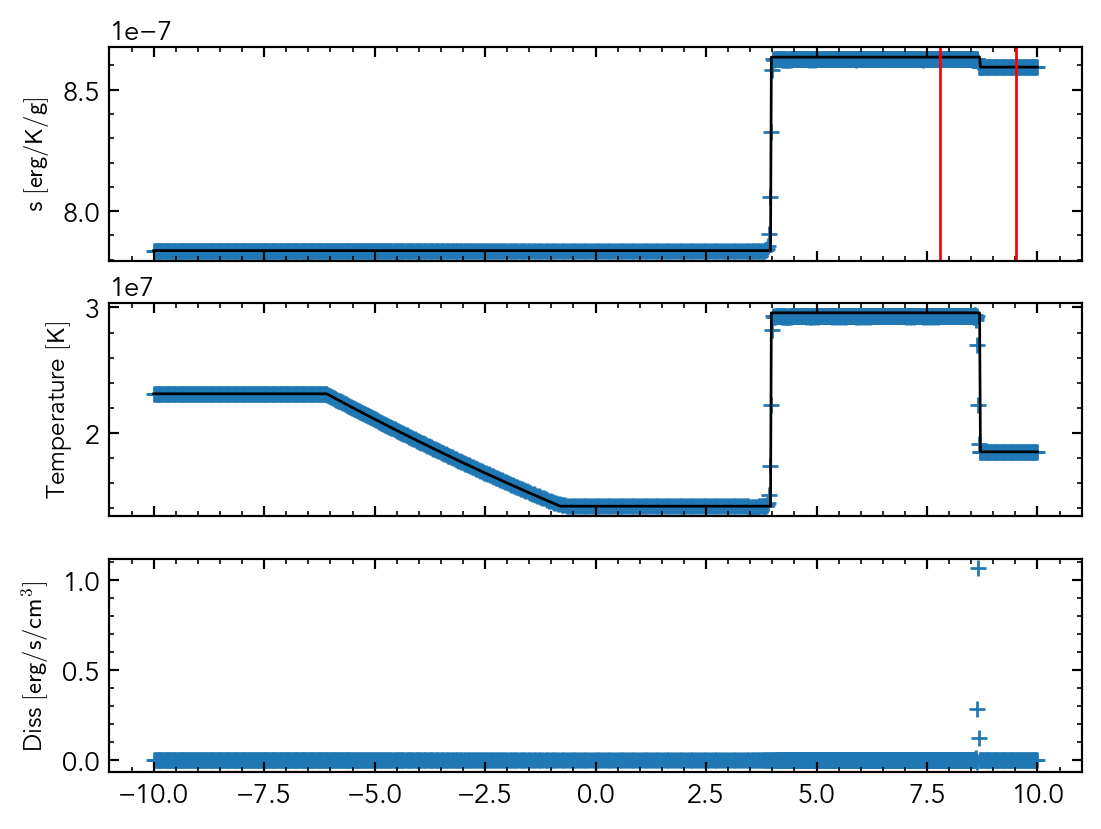

In [31]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].scatter(snap.x, s, marker='+')
ax[0].plot(x, s_exact, color='k')
ax[0].set_ylabel(r's $\mathsf{[erg/K/g]}$', fontsize=9)

ax[0].axvline(x1.value, color='r')
ax[0].axvline(x2.value, color='r')

ax[1].scatter(snap.x, T, marker='+')
ax[1].plot(x, T_exact, color='k')
ax[1].set_ylabel(r'Temperature $\mathsf{[K]}$', fontsize=9)

ax[2].scatter(snap.x, snap.dissipation, marker='+')
ax[2].set_ylabel(r'Diss $\mathsf{[erg/s/cm^3]}$', fontsize=9)

plt.show()

In [32]:
# T_1 (s_2 - s_1)
diss_sjump = T1 * (s2 * v2_sh * rho2 - s1 * v1_sh * rho1) * A
print(f"Dissipation rate across the shock front, as seen from entropy jump {diss_sjump}")

Dissipation rate across the shock front, as seen from entropy jump 6.362399128686623e-06 code_length**2*code_mass/code_time**3


In [33]:
diss_sh / diss_sjump

unyt_quantity(1.40210208, '(dimensionless)')

### Comparison 2
$$
\mathrm{Diss}\,\mathrm{[erg/s]} = (u_2 - u_1)\rho_1 v_\mathrm{sh} A
$$
subscript 1 for upstream, 2 for downstream. (Extremely strong shock)

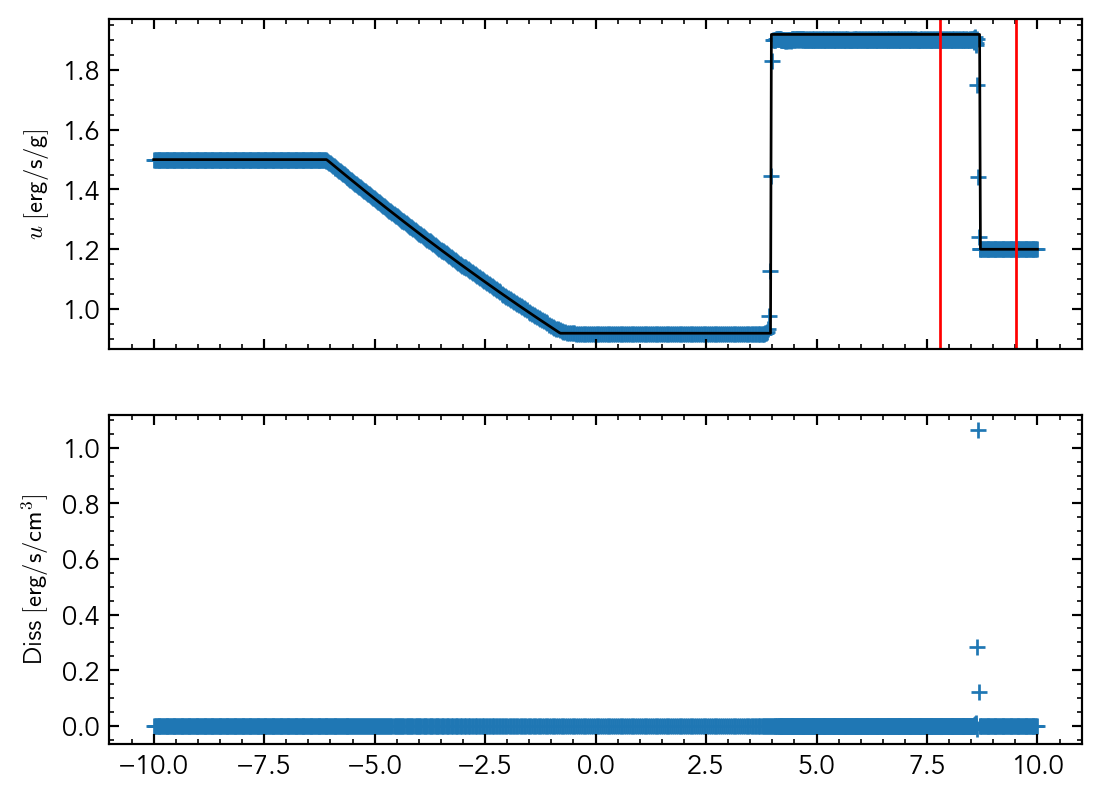

In [34]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(x=snap.x, y=snap.sie, marker='+')
ax[0].plot(x, P/rho*(3/2), color='k')
ax[0].set_ylabel(r'$u$ $\mathsf{[erg/s/g]}$', fontsize=9)
ax[0].axvline(x1.value, color='r')
ax[0].axvline(x2.value, color='r')

ax[1].scatter(snap.x, snap.dissipation, marker='+')
ax[1].set_ylabel(r'Diss $\mathsf{[erg/s/cm^3]}$', fontsize=9)

plt.show()

In [35]:
# Total dissipation rate diagnostic
# diss_ie = (u2 - u1) * rho1 * v_sh * A
diss_ie = (u2 - u1)* rho1 * v_sh * A
print(diss_ie)

6.433269148007872e-05 code_length**2*code_mass/code_time**3


In [36]:
diss_ie/diss_sh

unyt_quantity(7.21159251, '(dimensionless)')

### Comparison 3: Schaal+15, 16; Ryu+03
$$
\begin{gather}
E_\mathrm{diss} = \frac{1}{2} \rho_1 v_\mathrm{sh}^3 A \delta (M)
\\
\delta(M) = \frac{2}{\gamma(\gamma - 1)M^2 R} \left[\frac{2\gamma M^2 - (\gamma - 1)}{\gamma + 1} - R^\gamma\right]
\\
R = \frac{\rho_2}{\rho_1}
\end{gather}
$$

In [37]:
R = rho2/rho1
deltaM = 2/(gamma*(gamma - 1) * M**2 * R) * ((2*gamma*M**2 - (gamma - 1))/(gamma + 1) - R**gamma)
diss_schaal = 1/2*rho1*v_sh**3*A*deltaM
print(diss_schaal)

7.02160725594066e-06 code_length**2*code_mass/code_time**3


In [38]:
deltaM

unyt_quantity(0.04546464, '(dimensionless)')

In [39]:
print('RICH:', diss_sh, '\n', 'Entropy jump:', diss_sjump, '\n', 'Schaal+16:', diss_schaal, '\n', 'Internal energy jump:', diss_ie)

RICH: 8.920733031924458e-06 code_length**2*code_mass/code_time**3 
 Entropy jump: 6.362399128686623e-06 code_length**2*code_mass/code_time**3 
 Schaal+16: 7.02160725594066e-06 code_length**2*code_mass/code_time**3 
 Internal energy jump: 6.433269148007872e-05 code_length**2*code_mass/code_time**3


In [40]:
(u2 * rho2 - u1 * (rho2/rho1)**ga * rho1) * v2_sh * A # Also Schaal, without the delta(M) parametrisation

unyt_quantity(8.51064944e-06, 'code_length**2*code_mass/code_time**3')